# ANÁLISE PREDITIVA DO PREÇO DE VEÍCULOS 

## Descrição:
Primeira atividade do módulo 4 da disciplina 13 - Introdução a Ciência de Dados e Inteligência Artificial, do curso Talento Tech - PR.

## Objetivo:
Implementar um modelo para predição do preço de um veículo com base em suas características, tais como quilometragem, tipo de combustível, ano, etc.

## Ferramentas utilizadas:
O projeto foi desenvolvido em python, com as seguintes bibliotecas:
* Playwright, para raspagem de dados
* Pandas, para manipulação dos dados
* Scikit-Learn, para utilizar os modelos de previsão

---

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

#### Tabela de dados:

In [24]:
dados = pd.read_json("data/data.json")

dados = dados.drop_duplicates()
dados = dados[dados["Portas"] > 0]
dados["Faixa_Preco"] = pd.cut(
    dados["Preço"],
    bins=[0, 20000, 40000, 60000, 80000, 100000, 150000, 200000, 250000],
)

dados.sample(5)

,Preço,Marca,Modelo,Portas,Transmissão,Tipo,Ano,Quilometragem,Cor,Válvulas,Motor,Turbo,Estado,Combustível,Fipe,Faixa_Preco
8999,34900,HONDA,CIVIC,4,Automática,Sedã,2005,142880,Dourado,16,1.7,0,SC,Gasolina,146.0,"(20000, 40000]"
8442,33900,CHEVROLET,ASTRA,4,Manual,Hatchback,2010,205000,Prata,8,2.0,0,SP,Flex,103.0,"(20000, 40000]"
9385,19000,RENAULT,SANDERO,4,Manual,Hatchback,2011,196000,Prata,16,1.0,0,SP,Flex,83.0,"(0, 20000]"
4087,167500,HONDA,HR-V,4,CVT,Utilitário esportivo,2024,12500,Cinza,N/A,1.5,0,SP,Flex,102.0,"(150000, 200000]"
4754,235900,BMW,320i,4,Automática,Sedã,2022,48000,Cinza,16,2.0,0,SP,Flex,98.0,"(200000, 250000]"


---

#### Dados faltantes

Nota-se que há muitos dados faltantes sobre o número de válvulas:

In [25]:
dados_faltantes = dados[dados["Válvulas"] == "N/A"]
len(dados_faltantes)

5216

Olhando a correlação dos dados:

In [26]:
dados_hipotese = dados[dados["Válvulas"] != "N/A"]
print(len(dados_hipotese))
dados_hipotese[["Válvulas", "Preço"]].corr()

6596


,Válvulas,Preço
Válvulas,1.000000,-0.048903
Preço,-0.048903,1.000000


Como temos um número significativo de dados válidos, e dentro deles, há uma correlação muito próxima de zero, é razoável descartar essa característica, em virtude da inconsistência observada

In [27]:
dados = dados.drop(columns=["Válvulas"])

---

#### Marcas mais comuns nessa base de dados:

In [28]:
contagem_marcas = (
    dados.groupby("Marca")
    .agg(
        Contagem=("Modelo", lambda x: len(x)),
        Percentual=("Modelo", lambda x: round(len(x) / len(dados) * 100, 2)),
    )
    .reset_index()
)

contagem_marcas.sort_values(by="Contagem", ascending=False).head(5)

,Marca,Contagem,Percentual
7,CHEVROLET,1502,12.72
48,VOLKSWAGEN,1493,12.64
12,FIAT,1259,10.66
22,JEEP,757,6.41
38,RENAULT,666,5.64


---

#### Motores

Motores mais comuns na base de dados:

In [29]:
contagem_motores = dados.groupby("Motor").size().reset_index(name="Contagem")
contagem_motores.sort_values(by="Contagem", ascending=False).head(5)

motores_comuns = dados["Motor"].value_counts()
motores_comuns = motores_comuns[motores_comuns > 600].index

---

Modelos mais comuns na base de dados:

In [30]:
contagem_modelos = (
    dados.groupby("Modelo")
    .agg(
        Contagem=("Modelo", "size"), Preço_Médio=("Preço", lambda x: round(x.mean(), 2))
    )
    .reset_index()
)

contagem_modelos.sort_values(by="Contagem", ascending=False).head(10)

,Modelo,Contagem,Preço_Médio
323,ONIX,539,77323.29
130,COMPASS,342,146816.87
310,MOBI,327,54584.68
344,POLO,243,78729.23
283,KWID,233,51572.74
368,RENEGADE,231,96477.33
248,HB20,215,69107.53
448,TRACKER,196,107083.85
426,T-CROSS,184,120760.71
232,GOL,181,34511.62


---

#### Visualização e tratamento dos dados

Há alguns poucos registros sem dados do motor, que não nos interessam

In [31]:
print(len(dados[dados["Motor"] == "N/A"]))
dados = dados[dados["Motor"] != "N/A"]

209


Vamos retirar carros com preços maiores, para evitar ruídos

In [32]:
dados = dados[dados["Preço"] < 250000]

In [33]:
dados["Fipe"] = dados["Fipe"] * dados["Preço"] / 100
dados["Fipe"] = dados.groupby(["Modelo", "Ano"])["Fipe"].transform(lambda x: x.fillna(x.mean()))
dados = dados.dropna()

Analisando a relação entre algumas características e o preço do veículo:

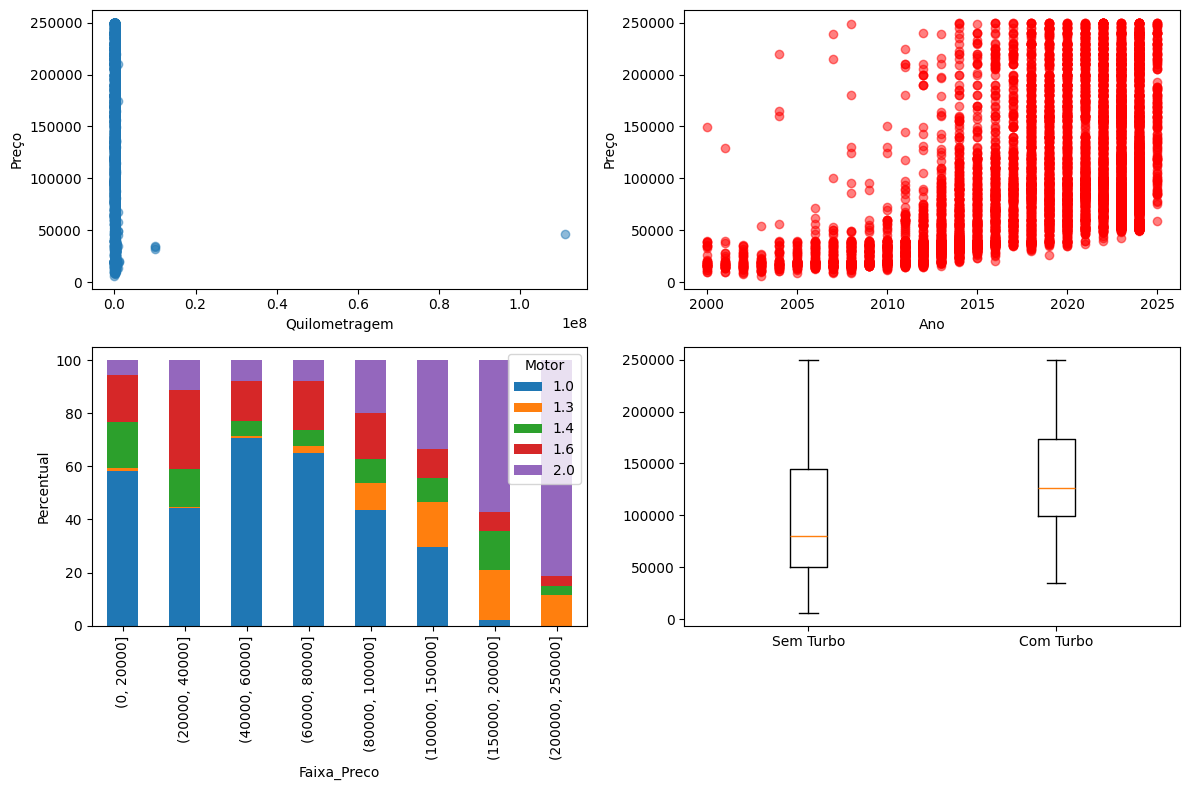

In [34]:
def analise_caracteristicas_preco(dados):
    dados: pd.DataFrame
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    distribuicao_motores = (
        dados[dados["Motor"].isin(motores_comuns)]
        .groupby("Faixa_Preco", observed=False)["Motor"]
        .value_counts(normalize=True,)
        .mul(100)
        .round(2)
    )

    axs[0, 0].scatter(dados["Quilometragem"], dados["Preço"], alpha=0.5)
    axs[0, 0].set_xlabel("Quilometragem")
    axs[0, 0].set_ylabel("Preço")

    axs[0, 1].scatter(dados["Ano"], dados["Preço"], alpha=0.5, color="red")
    axs[0, 1].set_xlabel("Ano")
    axs[0, 1].set_ylabel("Preço")

    axs[1, 1].boxplot(
        [dados["Preço"][dados["Turbo"] == 0], dados["Preço"][dados["Turbo"] == 1]],
        tick_labels=["Sem Turbo", "Com Turbo"],
        flierprops=dict(marker='o', markersize=8, markerfacecolor='red', linestyle='none')
    )

    distribuicao_motores.unstack().plot(kind="bar", stacked=True, ax=axs[1, 0])  
    axs[1, 0].set_ylabel("Percentual")

    plt.tight_layout()
    plt.show()

analise_caracteristicas_preco(dados)


É possível observar alguns dados inconsistentes sobre a quilometragem e o preço em alguns anos. Fazendo o tratamento:

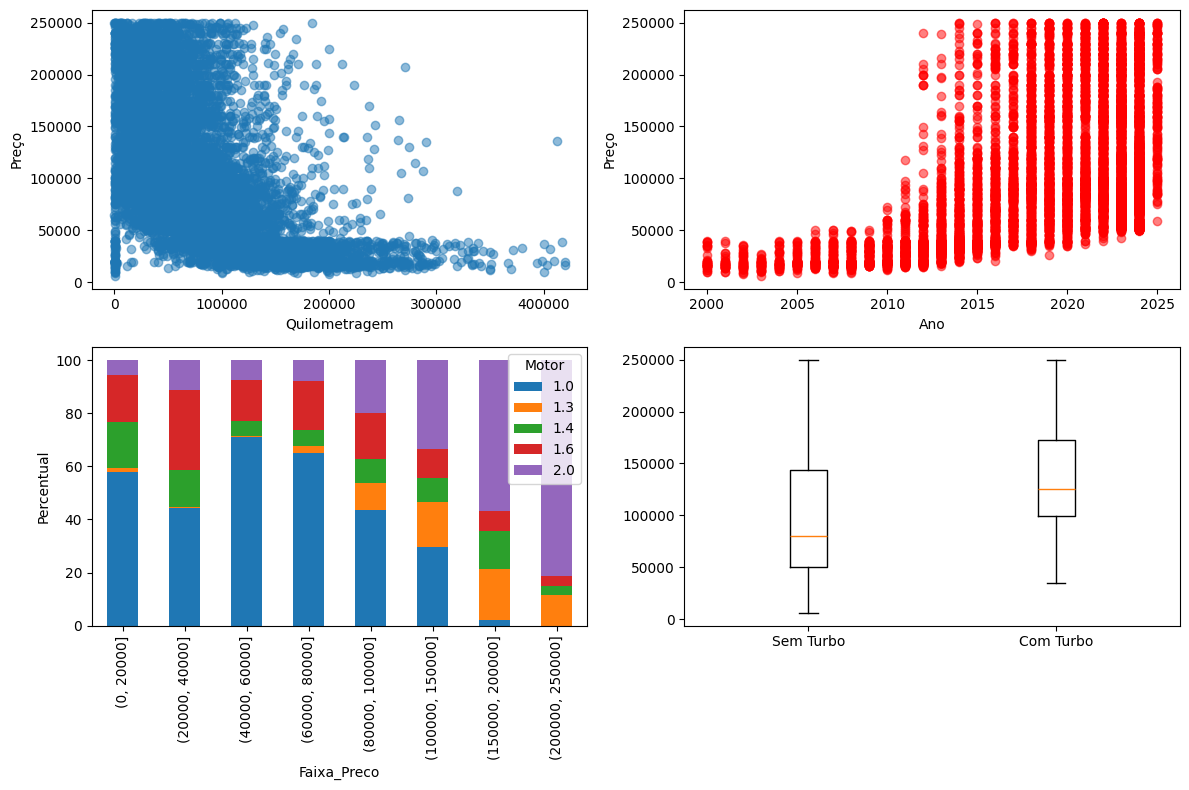

In [35]:
dados = dados[dados["Quilometragem"] < 500000]
dados = dados.drop(dados[(dados["Ano"] <= 2009) & (dados["Preço"] > 50000)].index)
dados = dados.drop(dados[(dados["Ano"] <= 2011) & (dados["Preço"] > 120000)].index)
dados[(dados["Quilometragem"] < 5000) & (dados["Ano"] < 2024)]

analise_caracteristicas_preco(dados)

---

## Atividade proposta
O objetivo da atividade proposta é treinar o modelo de Regressão Linear com base nas características relevantes do veículo. Adicionalmente, também usaremos o Random Forest.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error

In [37]:
import numpy as np

variaveis = ["Combustível", "Quilometragem", "Ano", "Motor", "Marca", "Modelo", "Tipo", "Transmissão", "Turbo", "Fipe"]
previsao = "Preço"

X = dados[variaveis]
y = dados[previsao]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_train)

num = ["Quilometragem", "Ano", "Turbo"]
cat = ["Combustível", "Motor", "Marca", "Modelo", "Transmissão", "Tipo"]

Na regressão, ao contrário de ser utilizado os valores reais do carro, foi utilizado uma escala logarítmica, a fim de evitar valores negativos nas predições

MAPE: 0.1036


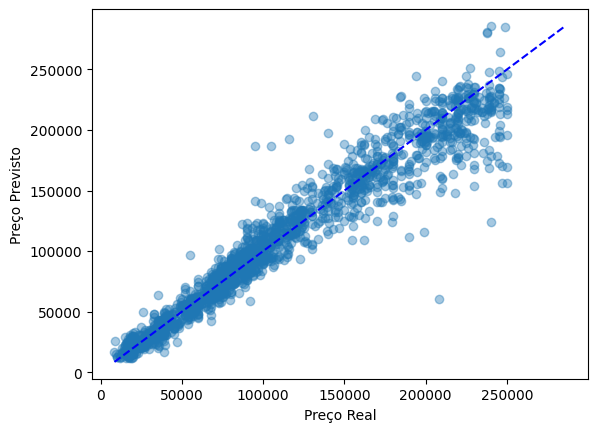

In [38]:

def grafico_de_dispersao(test, pred):
    plt.scatter(test, pred, alpha=0.4)

    min_value = min(min(test), min(pred))
    max_value = max(max(test), max(pred))
    plt.plot([min_value, max_value], [min_value, max_value], color="blue", linestyle="--", label="y = x")
    plt.xlabel("Preço Real")
    plt.ylabel("Preço Previsto")

    plt.show()

def regressao_linear(num, cat):
    preprocessador = ColumnTransformer(transformers=[
        ("num", StandardScaler(), num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat)
    ])

    modelo = Pipeline(steps=[
        ("preprocessador", preprocessador),
        ("regressor", LinearRegression())
    ])

    modelo.fit(X_train, y_train_log)

    y_pred_log = modelo.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"MAPE: {mape:.4f}")

    return y_test, y_pred

test, pred = regressao_linear(num, cat)

grafico_de_dispersao(test, pred)



Dessa forma, a regressão linear tem uma média de 10.36% de erro na previsão dos preços. Podemos também testar o Random Forest:

MAPE: 0.0993


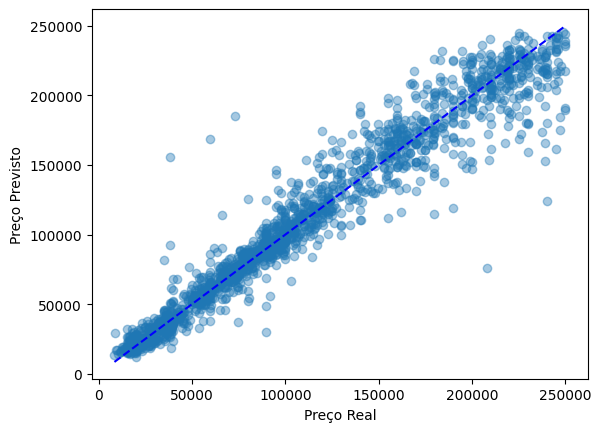

In [39]:
from sklearn.ensemble import RandomForestRegressor

def random_forest(num, cat):
    X = dados[variaveis]
    y = dados[previsao]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

    preprocessador = ColumnTransformer(transformers=[
        ("num", StandardScaler(), num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat)
    ])

    modelo = Pipeline(steps=[
        ("preprocessador", preprocessador),
        ("regressor", RandomForestRegressor(n_estimators=100, random_state=24))
    ])

    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)

    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"MAPE: {mape:.4f}")
    
    return y_test, y_pred

test, pred = random_forest(num, cat)

grafico_de_dispersao(test,pred)

Com o Random Forest, obtemos um erro médio menor, sendo de 9.93%. Para melhorar a acurácia da análise, é possível adicionarmos a FIPE do veículo na análise.

MAPE: 0.0741


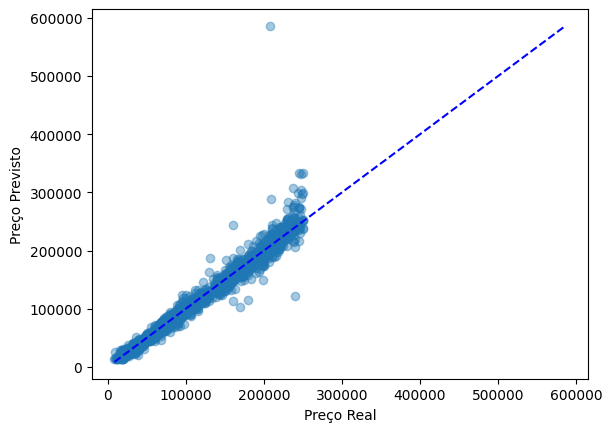

In [40]:
num = ["Quilometragem", "Ano", "Turbo", "Fipe"]
cat = ["Combustível", "Motor", "Marca", "Modelo", "Transmissão", "Tipo"]

test, pred = regressao_linear(num, cat)
grafico_de_dispersao(test, pred)

MAPE: 0.0497


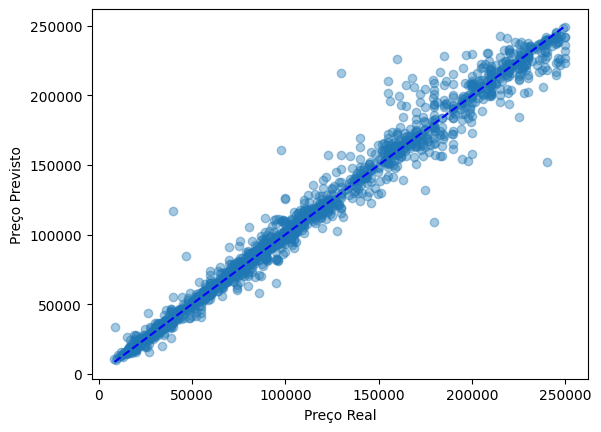

In [41]:
test, pred = random_forest(num, cat)
grafico_de_dispersao(test, pred)

Com a FIPE, o erro passa a ser de 7.41% para a Regressão Linear, e de 4.97% para o Random Forest.

#### Conclusão:
Tanto a Regressão Linear quanto o Random Forest conseguem se adequar de forma satisfatória aos dados. Em especial, com a FIPE, a acurácia é maximizada, embora possa gerar um possível viés nos modelos.